
Confusion Matrix:
[[55767   884]
 [   12    83]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.09      0.87      0.16        95

    accuracy                           0.98     56746
   macro avg       0.54      0.93      0.57     56746
weighted avg       1.00      0.98      0.99     56746

✅ LogisticRegression model and scaler saved.


C:\Users\Admin\AppData\Local\Temp\ipykernel_4144\4193965996.py:83: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Admin\OneDrive\Desktop\credit card froaud detector\vevofraud\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


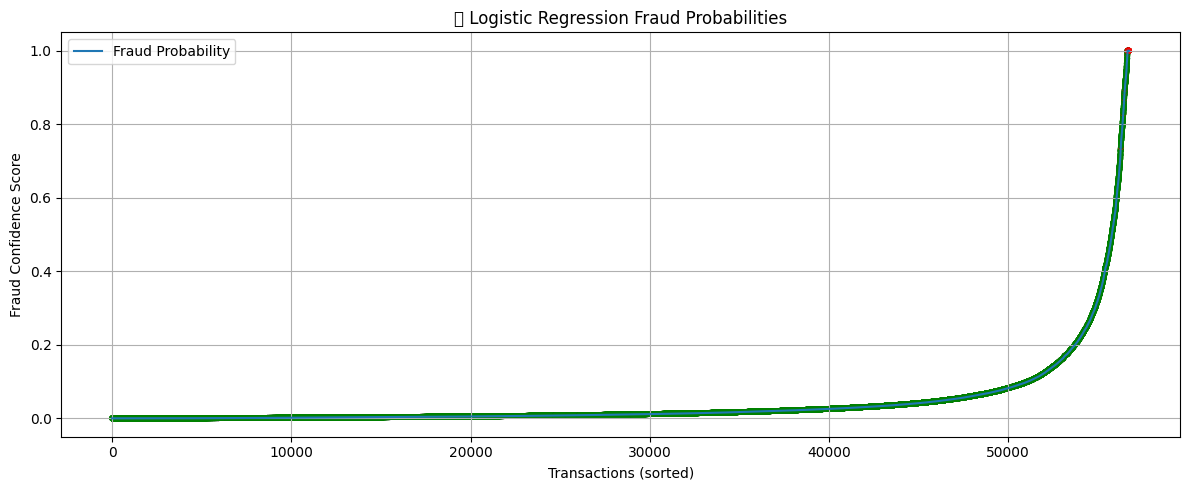

📈 Saved plot to outputs/fraud_prediction_plot_logreg.png


<Figure size 640x480 with 0 Axes>

In [7]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# === LOAD & CLEAN ===
df = pd.read_csv("../data/creditcard.csv")
df.drop_duplicates(inplace=True)

# === FEATURE ENGINEERING ===
df['Time_Hours'] = df['Time'] / 3600
df['Amount_SAR'] = df['Amount'] * 3.75
df.drop(columns=['Time', 'Amount'], inplace=True)

# === SPLIT FEATURES / LABELS ===
X = df.drop("Class", axis=1)
y = df["Class"]

# === SAVE MEDIANS + THRESHOLD ===
v_cols = [col for col in X.columns if col.startswith("V")]
combined_medians = df[v_cols].median().tolist()
joblib.dump(combined_medians, "../models/fraud_median_features.pkl")

amount_99 = df["Amount_SAR"].quantile(0.99)
joblib.dump(amount_99, "../models/amount_99th_percentile.pkl")

# === TRAIN-TEST SPLIT BEFORE SMOTE ===
X_train_raw, X_test, y_train_raw, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === SMOTE ONLY ON TRAIN SET ===
sm = SMOTE(sampling_strategy=0.1, random_state=42)
X_train, y_train = sm.fit_resample(X_train_raw, y_train_raw)

# === SCALE ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === TRAIN LOGISTIC REGRESSION ===
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# === EVALUATE ===
y_pred = model.predict(X_test_scaled)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# === SAVE MODEL + SCALER ===
joblib.dump(model, "../models/fraud_model.pkl")
joblib.dump(scaler, "../models/fraud_scaler.pkl")
print("✅ LogisticRegression model and scaler saved.")

# === PLOT PROBABILITIES ===
y_prob = model.predict_proba(X_test_scaled)[:, 1]

vis_df = pd.DataFrame({
    'True_Label': y_test.values,
    'Fraud_Probability': y_prob
}).sort_values(by='Fraud_Probability').reset_index(drop=True)

vis_df['Color'] = vis_df['True_Label'].map({0: 'green', 1: 'red'})

plt.figure(figsize=(12, 5))
plt.plot(vis_df['Fraud_Probability'], label='Fraud Probability')
plt.scatter(vis_df.index, vis_df['Fraud_Probability'], c=vis_df['Color'], s=10)
plt.title("📊 Logistic Regression Fraud Probabilities")
plt.xlabel("Transactions (sorted)")
plt.ylabel("Fraud Confidence Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

os.makedirs("../outputs", exist_ok=True)
plt.savefig("../outputs/fraud_prediction_plot_logreg.png", dpi=300)
print("📈 Saved plot to outputs/fraud_prediction_plot_logreg.png")

